# Exercises Week 10-11: Graded exercise session (part A)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2025-2026


In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import gammaln
%matplotlib inline


**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell before you submit.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. We will consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } k\,n \\
(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
\end{array}

We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

*Hint*: In all of the exercises below, use rates that are plausible biologically, especially for $s$ and $k$ (see course). Note that the units here are in minutes.

#### Question 1
1. Modify/complete the code template provided for the Gillespie algorithm to simulate the Telegraph model.

2. Two genes differ by the percentage of time the promoter is ON (gene1: 100%, gene2 : 10%), but the other parameters are the same ($s$, $k$). Let’s modify gene2 so that it expresses at the same level than gene 1, by either increasing its synthesis rate, or decreasing its degradation rate. Let’s say that you also aim to minimize the variance, which scenario is better? For each of the 4 cases (gene1, gene2, gene2 with synthesis rate up, gene2 with degradation rate down), answer with a simulation and show the distribution of the number of molecules and explain your findings.  
*Note*: For each case, report the variance, the mean level of expression, the expected number of molecules, the coefficient of variation of the number of mRNA copies ($CV=\frac{\sigma}{\mu}$) and the probability of the promoter to be in the $ON$ state.  

#### Gillespie template

In [2]:
import numpy as np

def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telepgrah process using the Gillespie algorithm.
    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0 or 1).
    parameters: Tuple containing transcription rate s, degradation rate k, switching rates k_on and k_off
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on, k_off = parameters 

    while t < t_end: 
        
        # Define the stoichiometric matrix S (also called state-change matrix) and rate vector for each promoter state
        if g == 1: # Promoter is active 
            S = np.array([
                [-1,  0],  # gene setting to inactive, rate k_off
                [ 0, +1],  # mRNA production, rate s
                [ 0, -1]   # natural mRNA degradation, rate k*n
            ])
            rates = np.array([k_off, s, k*n])
        else: # Promoter is inactive
            S = np.array([
                [+1,  0],  # gene switching to active, rate k_on
                [ 0, -1]   # natural mRNA degradation, rate k*n
            ])
            rates = np.array([k_on, k*n])

        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output at specified DT intervals (equally spaced output)
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT
        
        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]

    return n_print, g_print, t_print

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gillespie_telegraph(n, g, t):
    """
    Plots the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n: Species n counts over time.
    g: Promoter state g over time.
    t: Time points for each recorded reaction.

    """

    fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True)

    # Plotting the number of molecules n over time
    axs[0].plot(t, n, label = 'n(t)', color='darkblue')
    axs[0].set_ylabel('# molecules n')

    # Plotting the promoter activity over time
    axs[1].vlines(x=t, ymin=np.min(g), ymax=np.array(g), colors='teal', lw=2, label='promoter activity')
    axs[1].set_ylim(np.min(g), np.max(g)+0.1)  # Set y-limits to make the promoter states clear (0 and 1)
    axs[1].set_ylabel('Promoter State')
    
    # Common x-label
    plt.xlabel('time [min]')
    
    plt.show()

In [4]:
#Helper functions for analysis. For each case, report the variance, the mean level of expression, the expected number of molecules,
# the coefficient of variation of the number of mRNA copies, and the probability of the promoter to be in the ON state.
#Plot distribution of number of mRNA molecules
def plot_distribution(n, title=''):
    plt.figure(figsize=(8,5))
    plt.hist(n, bins=50, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Number of mRNA molecules')
    plt.ylabel('Frequency')
    plt.show()

def compute_stats(n, g):
    mean_n = np.mean(n)
    expected_n = mean_n #Expected number of molecules = mean level of expression
    var_n = np.var(n)
    cv_n = np.sqrt(var_n)/mean_n if mean_n != 0 else 0
    p_on = np.mean(g)
    return mean_n, expected_n, var_n, cv_n, p_on

#### Gene 1

In [5]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.02 # Degradation rate, 1/k = 50 min
k_off = 0 #Switching off rate, t_on = 1/k_off
k_on  = 1#/120 #Switching on rate, t_off = 1/k_on

p_on = 1 # Fraction of time the gene is ON

n_0 = s/k * p_on

t_end=10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

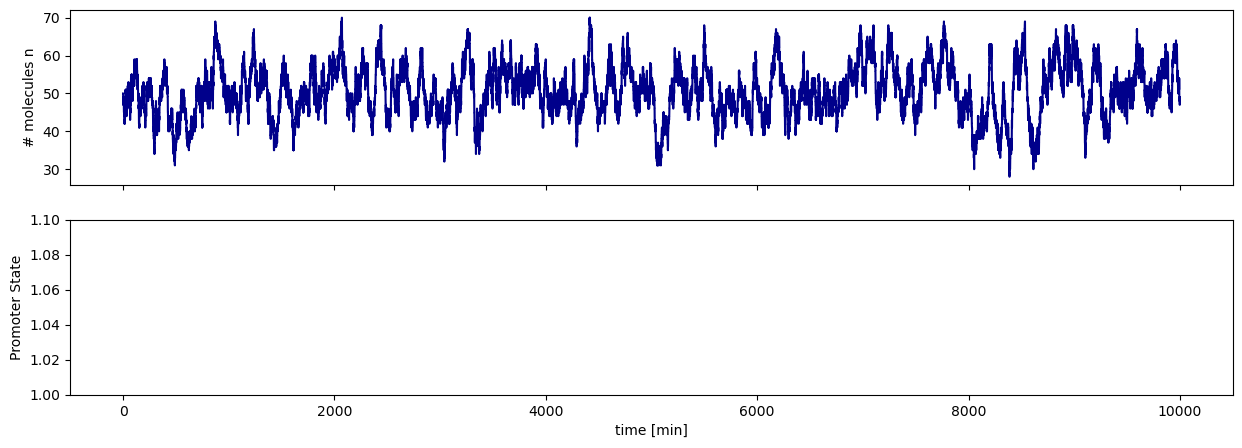

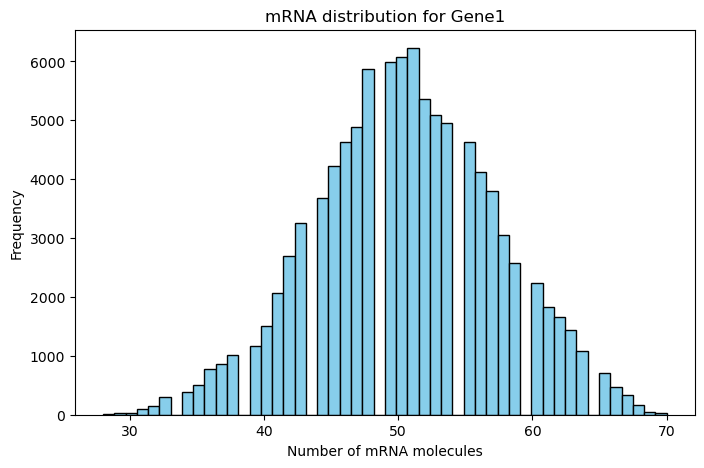

Mean level of expression: 50.55
Expected number of molecules: 50.55
Variance: 46.06
Coefficient of Variation (CV): 0.13
Probability promoter is ON: 1.00


In [6]:
#Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

#Plot time series of mRNA and promoter state
plot_gillespie_telegraph(n, g, t)

#Plot distribution of mRNA counts
plot_distribution(n, title='mRNA distribution for Gene1')

#Compute stats
mean_n, expected_n, var_n, cv_n, p_on = compute_stats(n, g)

print(f"Mean level of expression: {mean_n:.2f}")
print(f"Expected number of molecules: {expected_n:.2f}")
print(f"Variance: {var_n:.2f}")
print(f"Coefficient of Variation (CV): {cv_n:.2f}")
print(f"Probability promoter is ON: {p_on:.2f}")


Expected number of molecules in decimals because it's an statistical average. This is the “cleanest” case. When the promoter is always ON there are no bursts, so variability is low (CV: 0.15). This is the gold-standard reference. 

#### Gene 2

We need pon = 0.1, if we choose k_off=1/15, then k_on needs to be 1/135.

In [7]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.02  # Degradation rate
k_off = 1/15 #Switching off rate, unit min^-1, t_on = 1/k_off 
k_on  = 1/135 #Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off) # Needs to be 0.1, k_off and k_on adjusted accordingly

n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

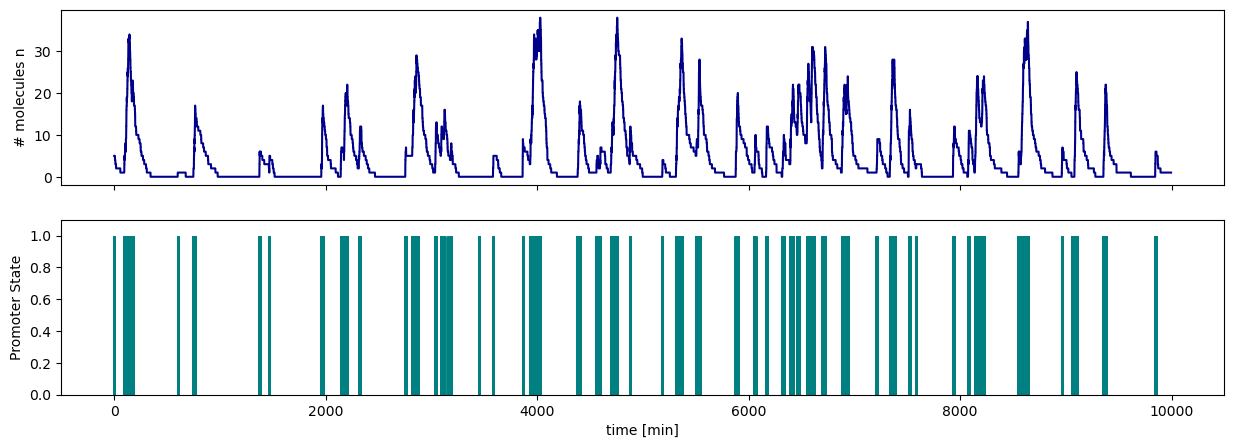

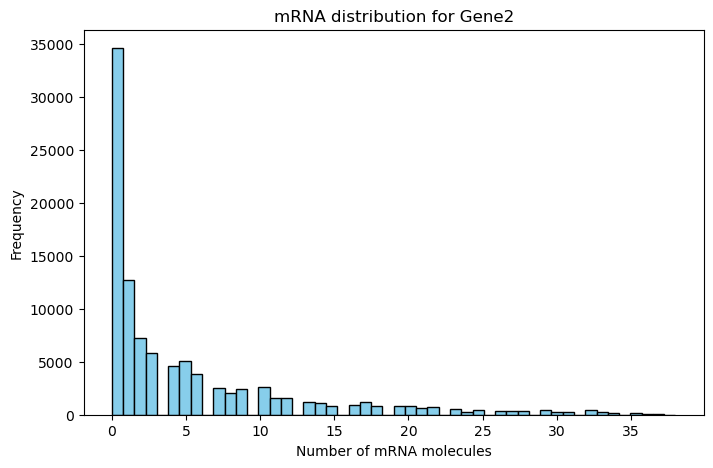

Mean level of expression: 5.07
Expected number of molecules: 5.07
Variance: 52.25
Coefficient of Variation (CV): 1.43
Probability promoter is ON: 0.10


In [8]:
#Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

#Plot time series of mRNA and promoter state
plot_gillespie_telegraph(n, g, t)

#Plot histogram of mRNA counts
plot_distribution(n, title='mRNA distribution for Gene2')

#Compute stats
mean_n, expected_n, var_n, cv_n, p_on = compute_stats(n, g)

print(f"Mean level of expression: {mean_n:.2f}")
print(f"Expected number of molecules: {expected_n:.2f}")
print(f"Variance: {var_n:.2f}")
print(f"Coefficient of Variation (CV): {cv_n:.2f}")
print(f"Probability promoter is ON: {p_on:.2f}")

When the promoter is ON only rarely, expression happens in bursts. This causes: small mean (4-5 molecules), very large fluctuations (CV: 1.38). This is classic bursting noise.

#### Gene 2 Increased synthesis rate

We want **gene 2** (which is ON only ~10% of the time) to have the same mean expression level as **gene 1**:

The mean expression of gene 1 is:

$ \mu_1 = \frac{s}{k} = \frac{1}{0.02} = 50 $

For gene 2, the probability of being ON is:

$ p_{\text{on}} = \frac{t_{\text{on}}}{t_{\text{on}} + t_{\text{off}}}, \quad t_{\text{on}} = 15, \, t_{\text{off}} = 135 $

$ p_{\text{on}} = \frac{15}{15 + 135} = 0.1 $

To make gene 2's mean expression equal to 50:

$ \mu_2 = \frac{s_2}{k_2} \, p_{\text{on}} = 50 $

Fixing degradation as for gene 1:

$ k_2 = 0.02 $

Solve for $s_2$:

$ 50 = \frac{s_2}{0.02} \cdot 0.1 $

$ 50 = 5 \, s_2 $

$ s_2 = 10 $


In [9]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 10 # Number of initiations per minute
k = 0.02 # Degradation rate
k_off = 1/15 #Switching off rate, unit min^-1, t_on = 1/k_off
k_on  = 1/135 #Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)

n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

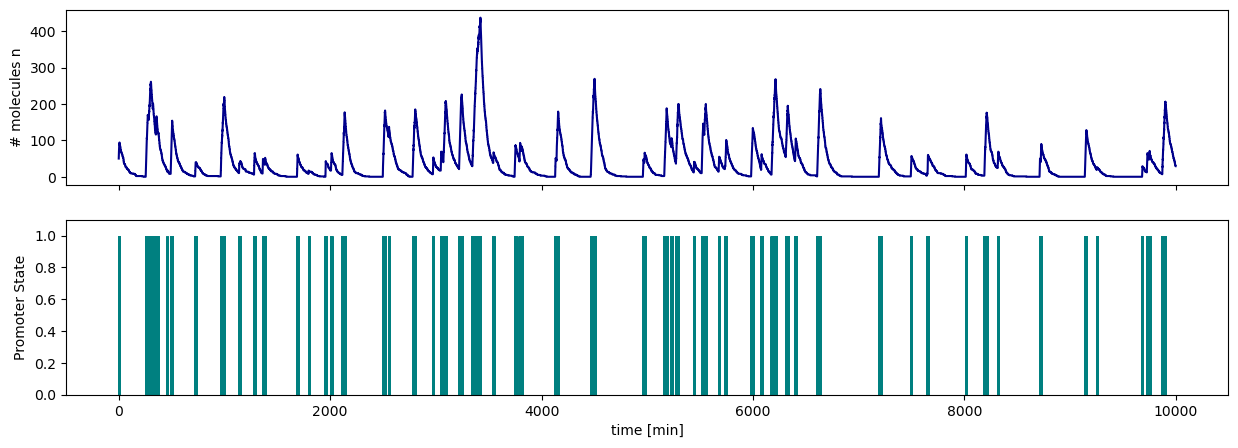

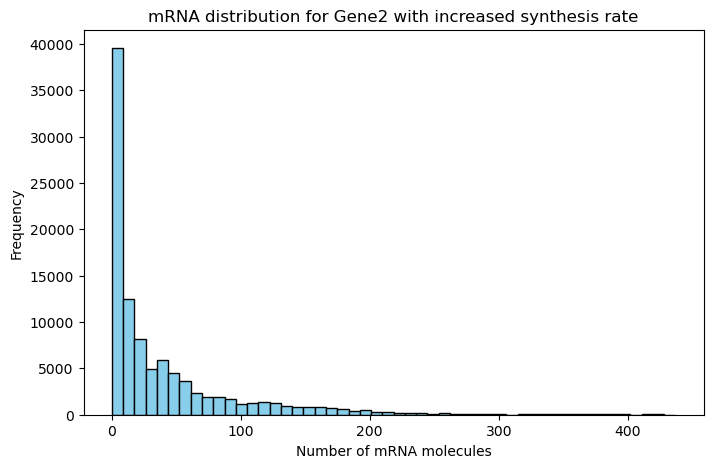

Mean level of expression: 38.84
Expected number of molecules: 38.84
Variance: 3138.16
Coefficient of Variation (CV): 1.44
Probability promoter is ON: 0.08


In [10]:
#Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

#Plot time series of mRNA and promoter state
plot_gillespie_telegraph(n, g, t)

#Plot distribution of mRNA counts
plot_distribution(n, title='mRNA distribution for Gene2 with increased synthesis rate')

#Compute stats
mean_n, expected_n, var_n, cv_n, p_on = compute_stats(n, g)

print(f"Mean level of expression: {mean_n:.2f}")
print(f"Expected number of molecules: {expected_n:.2f}")
print(f"Variance: {var_n:.2f}")
print(f"Coefficient of Variation (CV): {cv_n:.2f}")
print(f"Probability promoter is ON: {p_on:.2f}")

To match Gene 1’s mean, synthesis must increase 10× (explain from notes). But increasing synthesis does not change the fact that the promoter is OFF 90% of the time. So we now get: huge bursts when promoter turns ON (i dont see that change in the gillepsie plot), extremely large variance (≈5000), high noise (CV ≈ 1.3). This is the worst scenario in terms of noise. Noise increases because bursts become gigantic.

#### Gene 2 Reduced degradation rate

### Step 2: Solve for $k_2$

Steady-state mean expression:

$ \mu_2 = \frac{s}{k_2} p_{\text{on}} = 50 $

Plug in $s = 1$ and $p_{\text{on}} = 0.1$:

$ 50 = \frac{1}{k_2} \cdot 0.1 $

Solve for $k_2$:

$ k_2 = \frac{0.1}{50} = 0.002 $


In [11]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.002 # Degradation rate
k_off = 1/15 #Switching off rate unit min^-1, t_on = 1/k_off
k_on  = 1/135 #Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)


n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

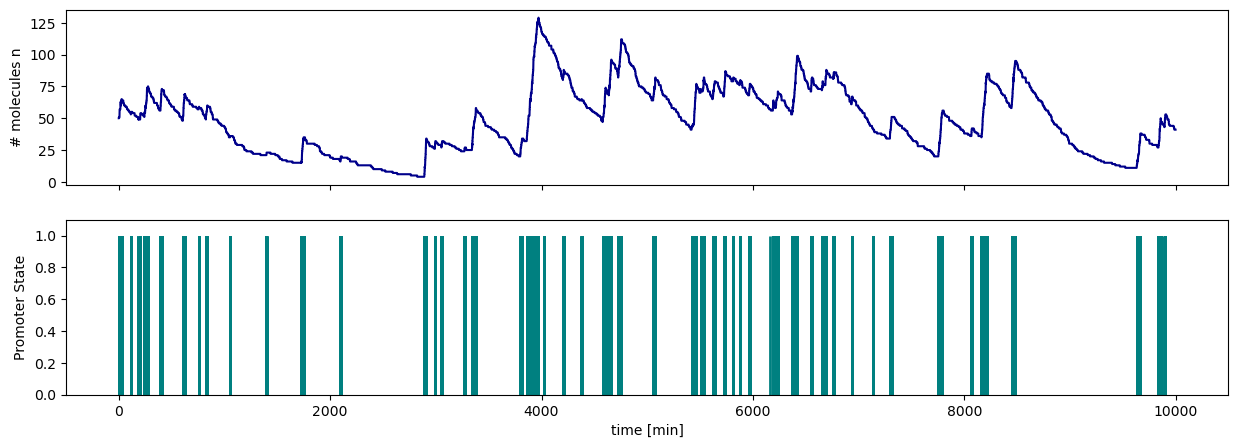

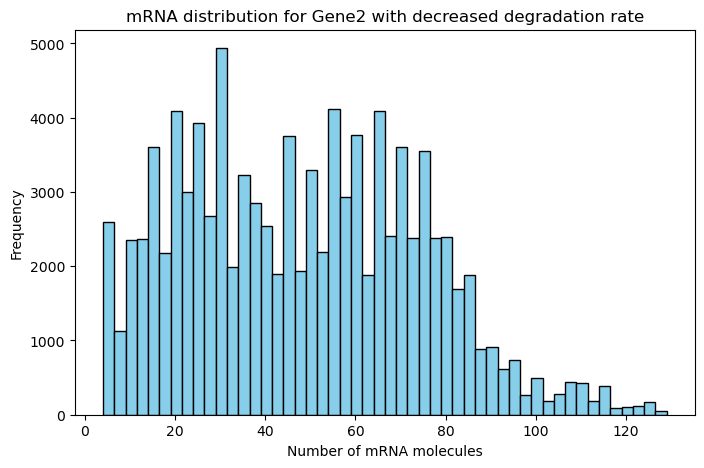

Mean level of expression: 48.14
Expected number of molecules: 48.14
Variance: 666.79
Coefficient of Variation (CV): 0.54
Probability promoter is ON: 0.09


In [12]:
#Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

#Plot time series of mRNA and promoter state
plot_gillespie_telegraph(n, g, t)

#Plot distribution of mRNA counts
plot_distribution(n, title='mRNA distribution for Gene2 with decreased degradation rate')

#Compute stats
mean_n, expected_n, var_n, cv_n, p_on = compute_stats(n, g)

print(f"Mean level of expression: {mean_n:.2f}")
print(f"Expected number of molecules: {expected_n:.2f}")
print(f"Variance: {var_n:.2f}")
print(f"Coefficient of Variation (CV): {cv_n:.2f}")
print(f"Probability promoter is ON: {p_on:.2f}")

Here you keep the promoter bursty, but make mRNAs live much longer. Key effect: Long-lived mRNA buffers out promoter switching noise. Noise drops drastically: mean 55 (close to Gene 1), variance : 400 (much higher than the 50 for gene 1), CV : 0.36 (much closer to Gene 1’s 0.13). This is far better than increasing synthesis.

Having seen the four simulations, we conclude that the best scenario is the last one in terms of minimizing the variance. If you want Gene 2 to look like Gene 1: Increasing synthesis makes noise explode. Because the gene still turns ON in rare bursts, but now each burst produces a huge pile of mRNAs. Decreasing degradation smooths out the bursts mRNAs accumulate slowly and decay slowly, so the system averages out the promoter’s randomness.

#### Question 2
1. Identify parameters that results in a Poisson distribution of mRNA numbers. Explain why these parameters produce a Poisson distribution. Show the empiral histogram and overlay an exact Poisson distribution. In this regime, explain how the parameters of the Telegraph model relate to the parameter of the Poisson distribution. *Hint*: $k_{off}=0$ with $g(t=0)=1$ is not the right answer. 

2. Find parameters where the mRNA distribution deviates from the Poisson. *Hint*: Look for a regime that yields a bimodal distribution. Explain your reasoning.  

####  Helper functions for the Poisson distribution

In [13]:
# Poisson distribution
def Poisson(lam, counts):
    """
    Calculate the Poisson distribution probability for given counts.
    
    Parameters:
    lam: The average number of events (rate parameter).
    counts: Observed counts.

    Returns:
    np.array: Probabilities corresponding to the observed counts.

    Notes:
    - This function uses the log-form of the Poisson probability mass function.
    - The gammaln function is used for calculating the logarithm of the factorial term.

    """

    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

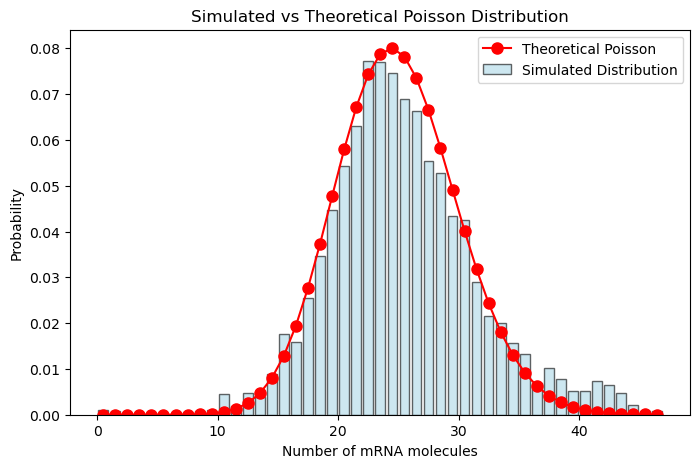

In [14]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state

##Find Parameters giving Poisson distribution
s = 50 # Number of initiations per minute 
k = 1 # Degradation rate,  unit min^-1
k_off = 200 #Switching off rate, unit min^-1, t_on = 1/k_off
k_on  = 200 #Switching on rate, unit min^-1, t_off = 1/k_on

n_0 = 0 # Initial mRNA count

DT = 0.01 # min

t_end = 100 * 1/k # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]
p_on = k_on / (k_on + k_off)

# Run the Gillepsie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the theoretical Poisson distribution vs the simulated one
mean_n, expected_n, var_n, cv_n, p_on = compute_stats(n, g)

counts, bins = np.histogram(n, bins=range(0, max(n)+2), density=True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
poisson_probs = Poisson(expected_n, bin_centers)
plt.figure(figsize=(8,5))
plt.bar(bin_centers, counts, width=0.8, alpha=0.6, label='Simulated Distribution', color='lightblue', edgecolor='black')
plt.plot(bin_centers, poisson_probs, 'ro-', label='Theoretical Poisson', markersize=8)
plt.title('Simulated vs Theoretical Poisson Distribution')
plt.xlabel('Number of mRNA molecules')
plt.ylabel('Probability')
plt.legend()
plt.show()


#### How to chose the Poisson parameters ? 
The parameters that give a Poisson ditribution are those where there is a fast promoter switching regime. Therefore, we chose k_on and k_off larger than s and k. 

A rapid switch means that the promoter occupation is averaged as the pormoter is ON for a fraction pon = kon / (kon + koff). 

They should be short compared to the lifecycle of the mRNA. 


#### Question 3 (Promoter cycle)
Transcription in mammals often requires a more complicated telegraph model (promoter cycle), where the promoter state goes through an $ON$ state, and then sequentially goes through several $OFF_n$ state before returning to the ON state. For example with two $OFF$ states, it would look like: $ON\,(g=1)\longrightarrow OFF_1 (g=2) \longrightarrow OFF_2 (g=3) \longrightarrow ON (g=1)$. This is related to the fact that transcription events often show a refractory period, *i.e.* promoter tend to say off for some amount of time before turning back on. 

1. Modify the above code to implement the promoter cycle with two $OFF$ state. First, use rates as in the example above with the following modifications: $s = 20$, $k = 0.02$, $k_{on-off_1} = 1/15$, $k_{off_1-off_2} = 1/60$ and $k_{off_2-on}  = 1/60$. Show some representative simulations. Plot both the mRNA and promoter state and comment.

2.  Study the distribution of the durations of each $OFF$ interval separately and study the distribution of the total duration of the two $OFF$ intervals. Focus on the shape of the distributions. Explain your findings.

3. (Bonus). Can you explain mathematically and biologically the shape of the distribution ? What would happen if you include more $OFF_n$ states?

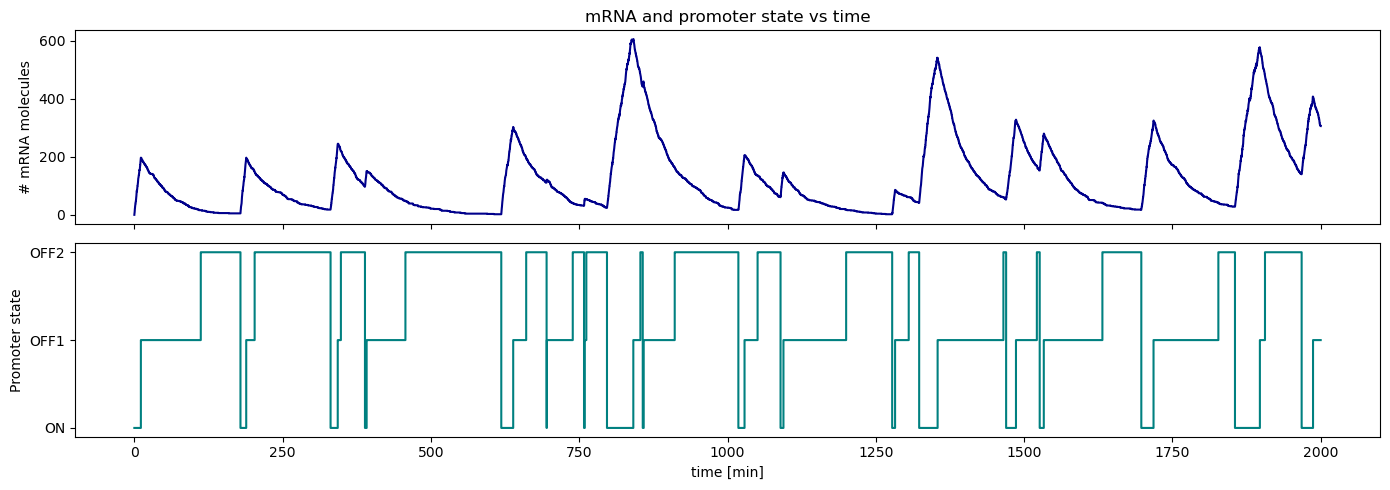

Simulation parameters: s=20, k=0.02, k_1to2=0.0667, k_2to3=0.0167, k_3to1=0.0167
Total simulated time: 2000.0 min, DT=0.1 min
Mean mRNA: 125.05, Variance: 15824.81, CV: 1.01, P(ON): 0.130


In [15]:
# Gillespie simulator for a promoter cycle with two OFF states:
# States: 1 = ON, 2 = OFF1, 3 = OFF2
import numpy as np
import matplotlib.pyplot as plt

def run_gillespie_promoter_cycle(n0, g0, parameters, t_end, DT):
    """
    Simulate promoter cycle 1 -> 2 -> 3 -> 1 with mRNA production in state 1.
    parameters: (s, k, k_1to2, k_2to3, k_3to1)
    Returns lists (n_print, g_print, t_print) sampled every DT.
    """
    n = int(n0)
    g = int(g0)
    t = 0.0
    tp = 0.0

    n_print = []
    g_print = []
    t_print = []

    s, k, k_1to2, k_2to3, k_3to1 = parameters

    while t < t_end:
        rates = []
        reactions = []

        # Define possible reactions depending on promoter state
        if g == 1:
            rates.extend([k_1to2, s, k * n])   # 1->2, synthesis, degradation
            reactions.extend(['1_to_2', 'synth', 'deg'])
        elif g == 2:
            rates.extend([k_2to3, k * n])      # 2->3, degradation
            reactions.extend(['2_to_3', 'deg'])
        elif g == 3:
            rates.extend([k_3to1, k * n])      # 3->1, degradation
            reactions.extend(['3_to_1', 'deg'])

        rates = np.array(rates, dtype=float)
        rates_tot = rates.sum()
        if rates_tot <= 0:
            break

        # Sample time to next reaction
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Record outputs at regular DT intervals (same behaviour as previous cells)
        while tp < t and tp <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT

        # Choose reaction
        r = np.random.random()
        cum = np.cumsum(rates) / rates_tot
        idx = np.searchsorted(cum, r)
        chosen = reactions[int(idx)]

        # Execute the chosen reaction
        if chosen == 'synth':
            n += 1
        elif chosen == 'deg':
            if n > 0:
                n -= 1
        elif chosen == '1_to_2':
            g = 2
        elif chosen == '2_to_3':
            g = 3
        elif chosen == '3_to_1':
            g = 1

    return n_print, g_print, t_print

def plot_promoter_cycle(n, g, t):
    """Plot mRNA and discrete promoter states (1,2,3).
    """
    fig, axs = plt.subplots(2, figsize=(14,5), sharex=True)

    axs[0].plot(t, n, color='darkblue')
    axs[0].set_ylabel('# mRNA molecules')
    axs[0].set_title('mRNA and promoter state vs time')

    # Plot promoter state as step plot for clarity
    axs[1].step(t, g, where='post', color='teal')
    axs[1].set_yticks([1,2,3])
    axs[1].set_yticklabels(['ON','OFF1','OFF2'])
    axs[1].set_ylabel('Promoter state')
    axs[1].set_xlabel('time [min]')

    plt.tight_layout()
    plt.show()

# ---- Run a representative simulation with the requested rates ----
# Parameters from the exercise
s = 20
k = 0.02
k_1to2 = 1/15.0    # ON -> OFF1
k_2to3 = 1/60.0    # OFF1 -> OFF2
k_3to1 = 1/60.0    # OFF2 -> ON

# initial conditions and simulation settings
n0 = 0
g0 = 1
DT = 0.1
t_end = 2000.0

params = (s, k, k_1to2, k_2to3, k_3to1)

# Run simulation
n_traj, g_traj, t_traj = run_gillespie_promoter_cycle(n0, g0, params, t_end, DT)

# Plot results
plot_promoter_cycle(n_traj, g_traj, t_traj)

# Compute simple stats and print them
n_arr = np.array(n_traj)
p_on = np.mean([1 if gg==1 else 0 for gg in g_traj])
mean_n = n_arr.mean() if n_arr.size>0 else 0.0
var_n = n_arr.var() if n_arr.size>0 else 0.0
cv_n = np.sqrt(var_n)/mean_n if mean_n>0 else np.nan
print(f'Simulation parameters: s={s}, k={k}, k_1to2={k_1to2:.4f}, k_2to3={k_2to3:.4f}, k_3to1={k_3to1:.4f}')
print(f'Total simulated time: {t_end} min, DT={DT} min')
print(f'Mean mRNA: {mean_n:.2f}, Variance: {var_n:.2f}, CV: {cv_n:.2f}, P(ON): {p_on:.3f}')